# Analysis of HD106315b (Visit 1) using `pycheops`

In the following notebook, we will analyse the data from `CHEOPS` visit 1 data of HD106315b using `pycheops`.

The method is similar to that used in the analysis of KELT-11b data ([https://github.com/Jayshil/pycheops-tutorials/blob/main/KELT-11/p2_kelt11_extra_decorr_parm.ipynb](https://github.com/Jayshil/pycheops-tutorials/blob/main/KELT-11/p2_kelt11_extra_decorr_parm.ipynb)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import lmfit as lmf
import re
from pycheops.utils import phaser

## Downloading the data

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR100041_TG000802_V0200.tgz
 PI name     : David EHRENREICH
 OBS ID      : 1040663
 Target      : HD 106315
 Coordinates : 12:13:53.40 -00:23:36.6
 Spec. type  : F5V
 G magnitude : 8.89 +- 0.00
Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR100041_TG000802_V0200-DEFAULT.fits
Time stored relative to BJD = 2458942
Aperture radius used = 25 arcsec
UTC start:  2020-04-02T22:44:17
UTC end:    2020-04-03T22:59:22
Visit duration: 87305 s
Exposure time: 1 x 41.0 s
Number of non-flagged data points: 1954
Efficiency (non-flagged data): 91.7 %
Light curve corrected for flux from background stars
Mean counts = 20093090.7
Median counts = 20092641.1
RMS counts = 12044.1 [599 ppm]
Median standard error = 4519.3 [225 ppm]
Median background = 235665 e-/pxl
Mean contamination = 13.0 ppm
Mean smearing correction = 8.3 ppm
Predicted amplitude of ramp = 121 ppm

Rejected 20 points more than 5.0 x MAD = 1029 ppm from the me

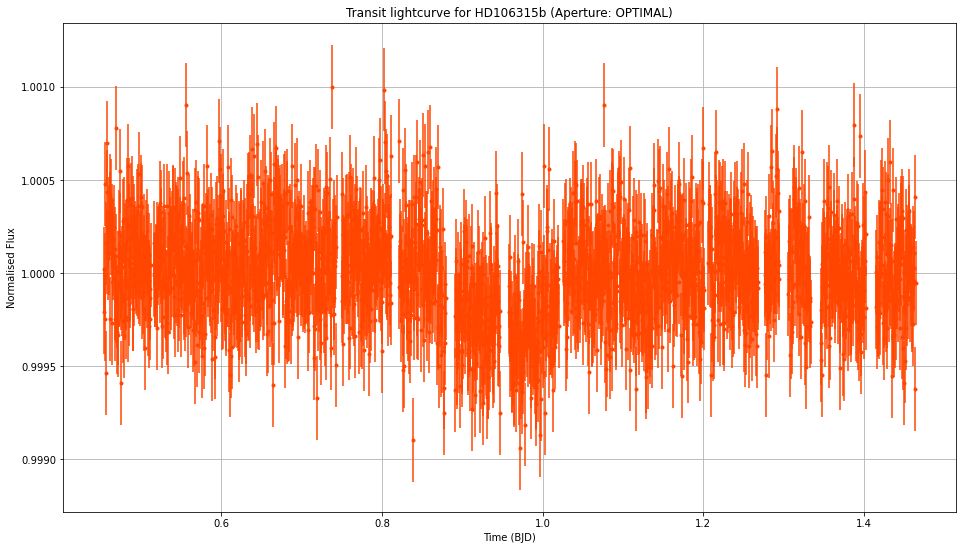

In [2]:
# Downloading data
dd = pycheops.Dataset('CH_PR100041_TG000802_V0200')
tim, fl, fle = dd.get_lightcurve(aperture='DEFAULT', decontaminate=True)#, reject_highpoints=True)

# To clip outliers (I would, in general, not prefer using this)
tim, fl, fle = dd.clip_outliers(verbose=True);

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for HD106315b (Aperture: OPTIMAL)')
plt.grid()

### Planetary check

We may want to check the position of various planetary bodies with respect to the target star, because if some of the bodies is very near to the target star then we may want to correct for their effects.

In [3]:
dd.planet_check()

BJD = 2458942.4539338206
Body     R.A.         Declination  Sep(deg)
-------------------------------------------
Moon     08:20:30.66  +22:06:00.9       9.5
Mars     20:17:34.20  -20:43:12.5      78.3
Jupiter  19:45:06.61  -21:18:39.3     100.1
Saturn   20:10:55.10  -20:06:00.5     111.7
Uranus   02:11:27.98  +12:45:28.8     147.3
Neptune  23:21:23.12  -05:16:09.0     164.9


## Stellar and Planetary properties

A knowledge of the stellar and planetary property of the system under investigation can proved to be useful while analysing the system. We can use some of the properties as priors in our analysis. In `pycheops` there are some in-build tools  available which ca go through the available stellar and planetary catalogues (like SWEET-Cat, or DACE) to give us the properties. Below, we show how to access such properties.

In [4]:
# For planetary properties
# This cell is copied from pycheops examples notebook
# The planet properties will not provide good results
# Hence, we will use ExoCTK to get planetary parameters.
"""
try: 
    hd106315b = pycheops.PlanetProperties('HD 106315b',query_dace=True)
except:
    hd106315b = pycheops.PlanetProperties('HD 106315b',query_dace=False, query_tepcat=False,
                                    depth = ufloat(298.909, 20.791),   # PPM
                                    width = ufloat(0.1572,0.0034),  # days (that means that is transit duration -- in days)
                                    ecosw=0.,#ufloat(-0.0040, 0.0490), 
                                    esinw=0.,#ufloat(0.0310, 0.0680),
                                    T0 = ufloat(2457586.5487, 0.0029),
                                    P = ufloat(9.55237, 0.00089))
    
print(hd106315b)
"""
# Using ExoCTK to get planetary properties
rprs = np.random.normal(0.01728, 0.0006, 10000)
dep, dep_err = np.mean((rprs**2)*1e6), np.std((rprs**2)*1e6)

Well..., apparently, I cannot (even after studying two semesters at Geneva) access DACE-Planets. No problem --- we have TEPCat at our service. We derived parameters from there. We can now try searching for the host star.

In [5]:
"""
star = pycheops.StarProperties(dd.target)
print(star)
"""
teff = np.random.normal(6450, 105, 10000)
logg = np.random.normal(4.28, 0.10, 10000)
mh = np.random.normal(-0.23, 0.14, 10000)
h1, h2 = np.zeros(10000), np.zeros(10000)
cdc = pycheops.ld.stagger_power2_interpolator('CHEOPS')
for i in range(len(teff)):
    c1, c2, h1[i], h2[i] = cdc(teff[i], logg[i], mh[i])

h1 = h1[np.isfinite(h1)]
h2 = h2[np.isfinite(h2)]

We have it! Here `h_1` and `h_2` are power2 law limb darkening coefficients.

## Renormalising the lightcurve

By a careful observation of the KELT-11 lightcurve, it can be observed that the out-of-transit values of the lightcurve is not equal to unity. So we may want to flatten the lightcurve using the `dataset.flatten` command as below,

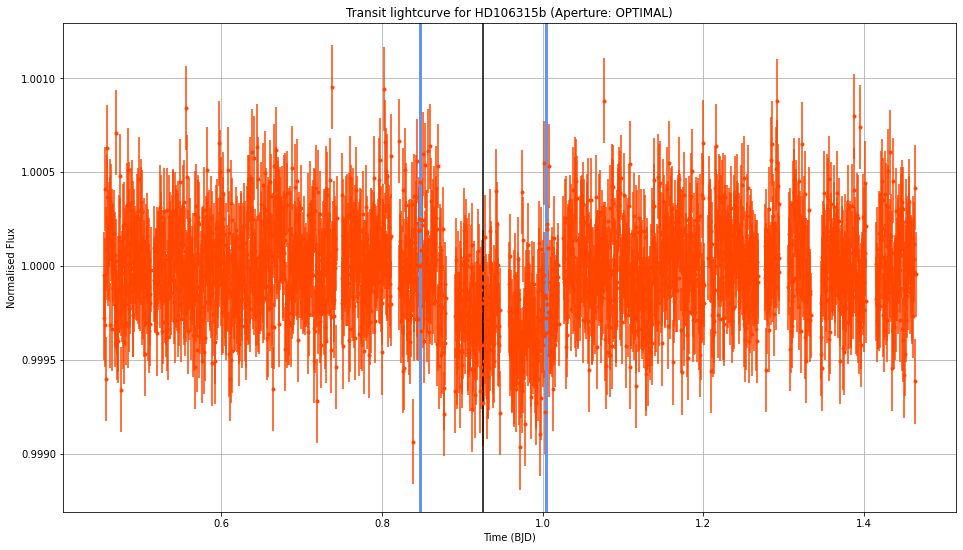

In [6]:
# This code is taken from the pycheops example notebook
P = 9.552105
BJD_0 = 2457586.5267
cycle = round((dd.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dd.bjd_ref + cycle*P

D = dep/1e6  # Depth stored in ppm
W = 0.15729166666666666/P    # Width stored in days

try:
    f_c = 0.#np.sqrt(0.093)*np.sin(67.0*np.pi/180)
    f_s = 0.#np.sqrt(0.093)*np.cos(67.0*np.pi/180)
except:
    # From Pepper et al., 2017
    ecosw = 0.#ufloat(-0.004,0.05099)
    esinw = 0.#ufloat(0.031,0.055)
    ecc = usqrt(ecosw**2+esinw**2)
    f_s = 0.#esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
    f_c = 0.#ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)


tim, fl, fle = dd.flatten(T_0, P*W)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.axvline(T_0, c='k')
plt.axvline(x=T_0-(W*P/2), c='cornflowerblue', lw=3)
plt.axvline(x=T_0+(W*P/2), c='cornflowerblue', lw=3)
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for HD106315b (Aperture: OPTIMAL)')
plt.grid()

## Detrending (or, decorrelating) the dataset

To perform this operation of detrending we may want to look at diagnostic report for this observations. The diagnostic report consist of various plots of flux as a function of several instrumental properties like roll angle of the spacecraft, centroid position etc. This would enable us to see if there is any trend going on with instruments so that we can take care of it. So, first let's see the diagnostic report...

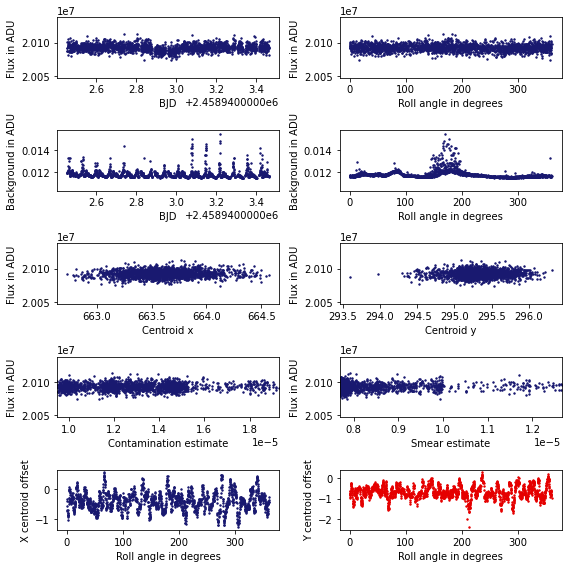

In [7]:
dd.diagnostic_plot()

### Ramp correction
A ramp in the flux is often observed, usually beginning the visit, in the lightcurves due to thermal effects (well, it primarily occurs due to small scale change in the shape of the PSF, which happens due to slightly more defocusing of the telescope. The main reason for the later is the thermal effects). The effect is well characterised for aperture radius between ~22 to 40 pixels. We can correct for this effect using the function `dataset.correct_ramp`.

Note that since this effect is well described only for a range of pixels, it is not advisable to make this correction if the aperture size is beyond this range.

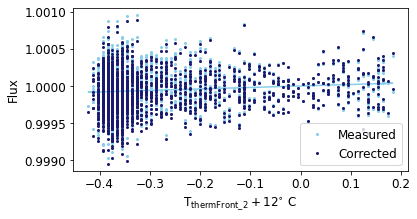

In [8]:
tim, fl, fle = dd.correct_ramp(plot=True)

### Performing decorrelation

We can see above that, `Dataset.should_I_decorr` function suggests that several decorrelations should be done. Various parameters shows different correlations with different properties of the instrument. From $\texttt{pycheops-cookbook}$ I mention where each of these parameters belong:

- flux versus time: $\texttt{dfdt}$, $\texttt{d2fdt2}$
- flux versus x-centroid: $\texttt{dfdx}$, $\texttt{d2fdx2}$
- flux versus y-centroid: $\texttt{dfdy}$, $\texttt{d2fdy2}$
- flux versus roll angle: $\texttt{dfdsinphi}$, $\texttt{dfdcosphi}$, $\texttt{dfdsin2phi}$, $\texttt{dfdcos2phi}$, $\texttt{dfdsin3phi}$, $\texttt{dfdcos3phi}$
- flux versus background: $\texttt{dfdbg}$
- flux versus contamination: $\texttt{dfdcontam}$
- flux versus smear: $\texttt{dfdsmear}$

Note that not each of the parameters have same units (especially $\texttt{dfdt}$), therefore, one may want to take care while defining these parameters in analysis.

There are (I think) two ways to take care of these correlations --- we can either use `dataset.decorr` function to take care of these correlations, or we can do it in the later stage of fitting the data. There is a little advantage of doing this in a later stage of curve fitting: if we do at that point, we can see the effect of <i>adding</i> parameters to the fitting with Bayes' factors. We can even neglect additional parameters which are not supported by the data.

Below, we try to include one by one parameter in the model and see its effect on the fitting in form of the Bayes' factor. However, before including decorrelation parameters, we fit <i>without</i> any decorrelation parameters. We can use results from this fitting as priors for the modelling which includes decorrelation parameters.

### Fitting without decorrelation

#### A note on using priors

The priors on the parameters can be find using `uncertainties` or `lmfit` module, or simply by using a tuple. To give normal priors with mean $\mu$ and standard deviation $\sigma^2$, one can use ufloat($\mu$, $\sigma^2$). A uniform prior with upper ($u$) and lower ($l$) bound can be given by a tuple ($l$, $u$), with initial value halfway of the range. If we want to specify the initial value ($in$), we can add it as a third term within the tuple, as ($l$, $in$, $u$). Furthermore, one can use [Parameter](https://lmfit.github.io/lmfit-py/parameters.html#the-parameter-class) object of `lmfit`. It can be defined as,

```
    lmfit.Parameter(name (str) = name of the parameter,
                    value (float) = numerical parameter value,
                    vary (bool) = Whether the parameter is varied during a fit (default is True,)
                    min (float) = lower bound (default is -np.inf),
                    max (float) = upper bound (default is np.inf),
                    expr (str) = mathematical expression used to constrain the value during the fit,
                    ***other kwargs)
```

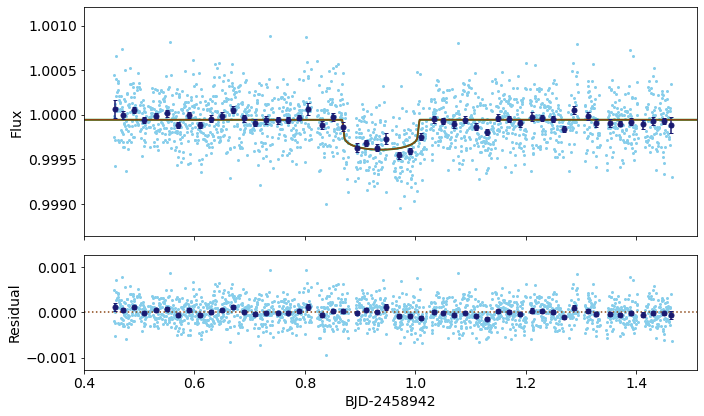

In [9]:
# Codes from the pycheops example notebook
lmfit0 = dd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P, 
                          D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                          f_c=f_c, f_s=f_s, 
                          h_1=np.mean(h1), h_2=np.mean(h2),
                          logrhoprior=ufloat(-0.229,0.045))

dd.plot_lmfit(binwidth=0.02, figsize=(10,6), fontsize=14);
#plt.ylim([-0.001, 0.001])

There is it! Our first fit using `pycheops`. We can see the diagnostic report below.

In [10]:
print(dd.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 1919
    # variables        = 5
    chi-square         = 2290.17643
    reduced chi-square = 1.19653941
    Akaike info crit   = -26411.2302
    Bayesian info crit = -26383.4324
    RMS residual       = 245.7 ppm
[[Variables]]
    T_0:     0.93767954 +/- 0.00115163 (0.12%) (init = 0.92561)
    P:       9.552105 (fixed)
    D:       3.2274e-04 +/- 1.8884e-05 (5.85%) (init = 0.0002988774)
    W:       0.01471857 +/- 2.3850e-04 (1.62%) (init = 0.0164667)
    b:       0.70048942 +/- 0.02912031 (4.16%) (init = 0.5)
    f_c:     0 (fixed)
    f_s:     0 (fixed)
    h_1:     0.7686241 (fixed)
    h_2:     0.4615287 (fixed)
    c:       0.99994342 +/- 6.0136e-06 (0.00%) (init = 1)
    k:       0.01796499 +/- 5.2558e-04 (2.93%) == 'sqrt(D)'
    aR:      15.9738107 +/- 0.58713210 (3.68%) == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:    0.99903802 +/- 8.0020e-05 (0.01%) == 'sqrt(1 - (b/aR)**2)'
    

### Fitting with decorrelation

We now attempt to fit the data with decorrelation parameters. As said previously, we add one by one decorrelation parameters in the fitting procedure and check the Bayes' factor each time.

We first want to check the RMS of the residuals which we can use as standard deviation of decorrelation parameters' priors in the fitting.

In [11]:
sigma0 = lmfit0.rms
dprior = ufloat(0, sigma0)
tprior = ufloat(0, sigma0/np.ptp(tim)) # Remember? Some of the priors, like dfdt, has different units.

In [12]:
# This code is taken from pycheops example notebook
detrend = {}
bestbf = 0
#"""
allpar = ['dfdsinphi','dfdcosphi',
          'dfdsin2phi','dfdcos2phi',
          'dfdsin3phi','dfdcos3phi',
          'dfdx', 'dfdy', 'dfdsmear',
          'dfdbg','dfdt', 'dfdcontam']
#"""
#allpar = ['dfdbg', 'dfdsmear', 'dfdt']#, 'dfdx', 'dfdy']

print('Parameter     BF     Delta_BIC RMS(ppm)')

while bestbf < 1:
    bestbf = np.inf
    for p in allpar: # This loop will put one by one parameter in the fit and see which one produce lowest Bayes' factor.
        dtmp = detrend.copy() ## Copy Updated detrend dictionary to temporary dtmp dict
        dtmp[p] = tprior if p == 'dfdt' else dprior
        lmfit = dd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s, 
                      h_1=np.mean(h1), h_2=np.mean(h2),
                      logrhoprior=ufloat(-0.229,0.045), **dtmp)
        bre = re.compile(r'{}: *(\d+\.\d{{3}})\n'.format(p))
        m = bre.findall(dd.lmfit_report())
        if len(m) > 0:
            bf = float(m[-1])
            if bf < bestbf:
                bestbf = bf
                newpar = p

    if bestbf < 1: # This condition will add lowest Bayes' factor parameter into detrend dict. if it has Bayes' factor <1
        print(f'+{newpar:<12s} {bestbf:6.2f}  {lmfit.bic-lmfit0.bic:8.1f} {1e6*lmfit.rms:8.1f}')
        detrend[newpar] = tprior if newpar == 'dfdt' else dprior
        allpar.remove(newpar) # If parameter is added to the dict then get removed from list of all parameters

# This process sometimes leads to a set of parameters that includes a few parameters that are strongly correlated with one another 
# and so are therefore not well determined, i.e. they have large Bayes factors. 
# So, after adding parameters one-by-one, go through a process of repeatedly removing the parameter with the largest Bayes factor 
# if any of the parameters have a Bayes factors Bp>1.

worstbf = 10
while worstbf > 1:
    worstbf = 0
    for p in detrend: # This loop finds the parameter with largest Bayes' factor
        bre = re.compile(r'{}: *(\d+\.\d{{3}})\n'.format(p))
        m = bre.findall(dd.lmfit_report())
        if len(m) > 0:
            bf = float(m[-1])
            if bf > worstbf:
                worstbf = bf
                delpar = p
    if worstbf > 1: # This condition removes the parameter with largest Bayes' factor if it is >1
        del detrend[delpar] 
        lmfit = dd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s, 
                      h_1=np.mean(h1), h_2=np.mean(h2),
                      logrhoprior=ufloat(-0.229,0.045), **detrend)
        print(f'-{delpar:<12s} {worstbf:6.2f}  {lmfit.bic-lmfit0.bic:8.1f} {1e6*lmfit.rms:8.1f}')

Parameter     BF     Delta_BIC RMS(ppm)
+dfdt           0.01       7.0    245.7
+dfdx           0.01     -22.6    243.7
+dfdcos2phi     0.03     -12.8    243.8
+dfdsinphi      0.51     -20.4    243.0
+dfdsmear       0.65     -22.9    242.4


The remained parameters which would be useful in decorrelating are (the ones which are stored in `detrend` dictionary). Note that the different between BIC is reducing with each addition/removal of the parameter.

In [13]:
print(detrend)

{'dfdt': 0.0+/-0.0002431819961926563, 'dfdx': 0.0+/-0.00024572408194171, 'dfdcos2phi': 0.0+/-0.00024572408194171, 'dfdsinphi': 0.0+/-0.00024572408194171, 'dfdsmear': 0.0+/-0.00024572408194171}


We can now use this parameters to detrend the dataset using the `lmfit_transit` function.

In [14]:
lmfit1 = dd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P,
                          D=(D/4, D, D*4), W=(W/4, W, W*4), b=(0,0.5,1),
                          f_c=f_c, f_s=f_s,
                          h_1=np.mean(h1), h_2=np.mean(h2),
                          logrhoprior=ufloat(-0.229,0.045), **detrend)

# Note the usage of .n in star.h_2.n which means that it will retrieve only one value and thus fixing the parameter.
print(dd.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 204
    # data points      = 1919
    # variables        = 10
    chi-square         = 2224.33672
    reduced chi-square = 1.16518424
    Akaike info crit   = -26467.0699
    Bayesian info crit = -26411.4743
    RMS residual       = 242.2 ppm
[[Variables]]
    T_0:         0.93749691 +/- 0.00114942 (0.12%) (init = 0.92561)
    P:           9.552105 (fixed)
    D:           3.1918e-04 +/- 1.8827e-05 (5.90%) (init = 0.0002988774)
    W:           0.01473804 +/- 2.4018e-04 (1.63%) (init = 0.0164667)
    b:           0.69979487 +/- 0.03006962 (4.30%) (init = 0.5)
    f_c:         0 (fixed)
    f_s:         0 (fixed)
    h_1:         0.7686241 (fixed)
    h_2:         0.4615287 (fixed)
    c:           0.99993601 +/- 6.8893e-06 (0.00%) (init = 1)
    dfdsmear:    6.6490e-05 +/- 2.9428e-05 (44.26%) (init = 0)
    dfdx:        6.5388e-05 +/- 1.6942e-05 (25.91%) (init = 0)
    dfdt:       -8.0193e-05 +/- 1.8980e-05 (2

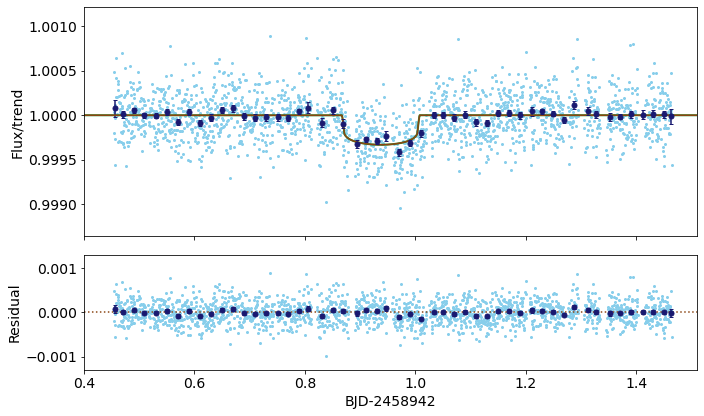

In [15]:
# We can plot the fitting
dd.plot_lmfit(binwidth=0.02, figsize=(10,6), fontsize=14, detrend=True);
#plt.ylim([-0.001, 0.001])

In above plot, light blue points are flux/trend, while the dark blue ones are the binned flux/trend. Transit model is shown in green and (transit model/trend) is brown line.

We can now check the roll angle plot to see if there is any trend remains. `dataset.rollangle_plot` gives the plot of residuals in the last fit with respect to the roll angle.

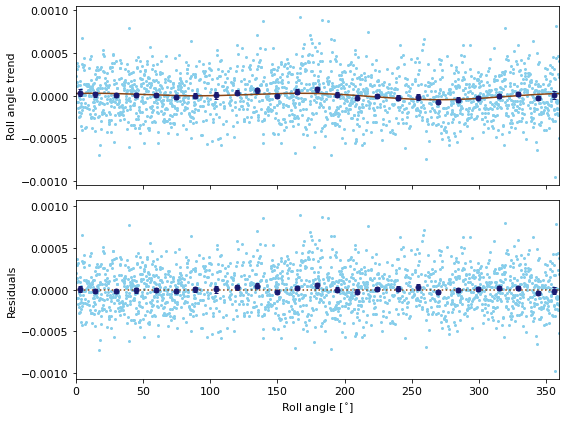

In [16]:
fig = dd.rollangle_plot()
#plt.ylim([-0.00075, 0.00075])

#### Adding glint and moon-glint

Apparently, when the observations were taken, moon was very near ($\sim 16^\circ$) to the target star. And the position of the moon changes significantlly during the observations. Therefore we may want to correct for this effect. Now, since we have already corrected for glint, we want to mask the transit and perform this moon gling only over out of transit points. To do so we create a mask. Then we will add moon glint for out of transit points.

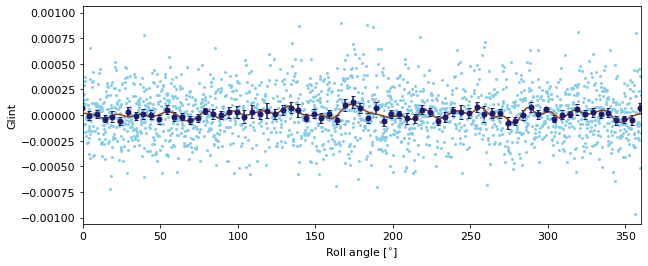

In [17]:
glint_func = dd.add_glint(nspline=48,binwidth=5,figsize=(10,4),gapmax=5)
#plt.ylim([-0.001, 0.001])

In [18]:
dd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P, 
                 D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                 f_c=f_c, f_s=f_s, 
                 h_1=np.mean(h1), h_2=np.mean(h2),
                 logrhoprior=ufloat(-0.229,0.045), **detrend,
                 glint_scale=(0,2))
print(dd.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 104
    # data points      = 1919
    # variables        = 11
    chi-square         = 2178.49751
    reduced chi-square = 1.14177018
    Akaike info crit   = -26510.9091
    Bayesian info crit = -26449.7539
    RMS residual       = 239.7 ppm
[[Variables]]
    T_0:          0.93743090 +/- 0.00114516 (0.12%) (init = 0.92561)
    P:            9.552105 (fixed)
    D:            3.1691e-04 +/- 1.8332e-05 (5.78%) (init = 0.0002988774)
    W:            0.01471964 +/- 2.2685e-04 (1.54%) (init = 0.0164667)
    b:            0.70102084 +/- 0.02785393 (3.97%) (init = 0.5)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    h_1:          0.7686241 (fixed)
    h_2:          0.4615287 (fixed)
    c:            0.99992933 +/- 6.9035e-06 (0.00%) (init = 1)
    dfdsmear:     5.4101e-05 +/- 2.9186e-05 (53.95%) (init = 0)
    dfdx:         5.9591e-05 +/- 1.6796e-05 (28.19%) (init = 0)
    dfdt:        -7.9779e-05 +/- 

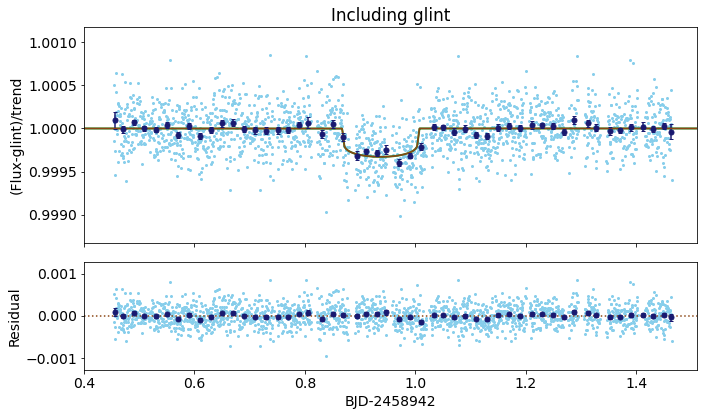

In [19]:
dd.plot_lmfit(binwidth=0.02, figsize=(10,6), fontsize=14, detrend=True,
              title='Including glint');
#plt.ylim([-0.001, 0.001])

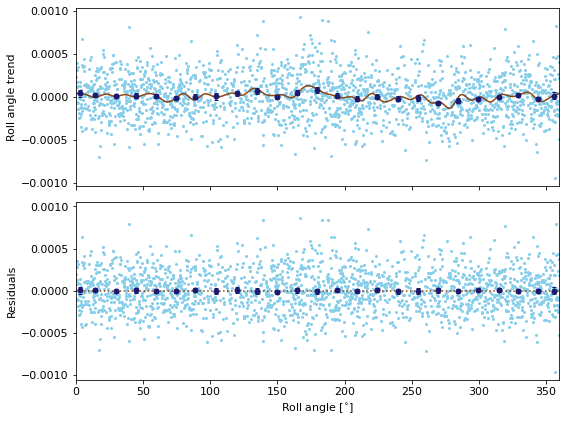

In [20]:
fig = dd.rollangle_plot()
#plt.ylim([-0.001, 0.001])

In [21]:
""" Commenting out moon glint as the normal glint is, I think, working well!!
phase = phaser(tim,lmfit.params['P'],lmfit.params['T_0'],-0.5)
mask = abs(phase) < lmfit.params['W']/2

moon_glint = dd.add_glint(moon=True,nspline=48,binwidth=5,
                          fit_flux=True, mask=mask,
                          figsize=(10,5))

#plt.ylim([-0.001, 0.001])
"""

" Commenting out moon glint as the normal glint is, I think, working well!!\nphase = phaser(tim,lmfit.params['P'],lmfit.params['T_0'],-0.5)\nmask = abs(phase) < lmfit.params['W']/2\n\nmoon_glint = dd.add_glint(moon=True,nspline=48,binwidth=5,\n                          fit_flux=True, mask=mask,\n                          figsize=(10,5))\n\n#plt.ylim([-0.001, 0.001])\n"

In [22]:
"""
dd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P, 
                 D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                 f_c=f_c, f_s=f_s, 
                 h_1=star.h_1, h_2=star.h_2.n,
                 logrhoprior=star.logrho, **detrend,
                 glint_scale=(0,2))
 
print(dd.lmfit_report(min_correl=0.5))
"""

'\ndd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P, \n                 D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),\n                 f_c=f_c, f_s=f_s, \n                 h_1=star.h_1, h_2=star.h_2.n,\n                 logrhoprior=star.logrho, **detrend,\n                 glint_scale=(0,2))\n \nprint(dd.lmfit_report(min_correl=0.5))\n'

In [23]:
worstbf = 10
while worstbf > 1:
    worstbf = 0
    for p in detrend: # This loop finds the parameter with largest Bayes' factor
        bre = re.compile(r'{}: *(\d+\.\d{{3}})\n'.format(p))
        m = bre.findall(dd.lmfit_report())
        if len(m) > 0:
            bf = float(m[-1])
            if bf > worstbf:
                worstbf = bf
                delpar = p
    if worstbf > 1: # This condition removes the parameter with largest Bayes' factor if it is >1
        del detrend[delpar] 
        lmfit = dd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s, 
                      h_1=np.mean(h1), h_2=np.mean(h2),
                      logrhoprior=ufloat(-0.229,0.045), **detrend)
        print(f'-{delpar:<12s} {worstbf:6.2f}  {lmfit.bic-lmfit0.bic:8.1f} {1e6*lmfit.rms:8.1f}')

## Fitting for the rest of the parameters
dd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P, 
                 D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                 f_c=f_c, f_s=f_s, 
                 h_1=np.mean(h1), h_2=np.mean(h2),
                 logrhoprior=ufloat(-0.229,0.045), **detrend,
                 glint_scale=(0,2))
 
print(dd.lmfit_report(min_correl=0.5))

-dfdsmear       1.51     -29.7    242.5
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 83
    # data points      = 1919
    # variables        = 10
    chi-square         = 2183.40262
    reduced chi-square = 1.14374155
    Akaike info crit   = -26508.0040
    Bayesian info crit = -26452.4084
    RMS residual       = 239.9 ppm
[[Variables]]
    T_0:          0.93788577 +/- 8.9935e-04 (0.10%) (init = 0.92561)
    P:            9.552105 (fixed)
    D:            3.1766e-04 +/- 1.8332e-05 (5.77%) (init = 0.0002988774)
    W:            0.01463261 +/- 1.6919e-04 (1.16%) (init = 0.0164667)
    b:            0.70797178 +/- 0.02627899 (3.71%) (init = 0.5)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    h_1:          0.7686241 (fixed)
    h_2:          0.4615287 (fixed)
    c:            0.99993514 +/- 6.0762e-06 (0.00%) (init = 1)
    dfdx:         5.5556e-05 +/- 1.6684e-05 (30.03%) (init = 0)
    dfdt:        -7.9856e-05 +/- 1.8803e-05 (23.55%) (init

In [24]:
#del detrend['dfdbg']

result = dd.lmfit_transit(T_0 = ufloat(T_0, 0.1), P=P, 
                 D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                 f_c=f_c, f_s=f_s, 
                 h_1=np.mean(h1), h_2=np.mean(h2),
                 logrhoprior=ufloat(-0.229,0.045), **detrend,
                 glint_scale=(0,2))
 
print(dd.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 83
    # data points      = 1919
    # variables        = 10
    chi-square         = 2183.40262
    reduced chi-square = 1.14374155
    Akaike info crit   = -26508.0040
    Bayesian info crit = -26452.4084
    RMS residual       = 239.9 ppm
[[Variables]]
    T_0:          0.93788577 +/- 8.9935e-04 (0.10%) (init = 0.92561)
    P:            9.552105 (fixed)
    D:            3.1766e-04 +/- 1.8332e-05 (5.77%) (init = 0.0002988774)
    W:            0.01463261 +/- 1.6919e-04 (1.16%) (init = 0.0164667)
    b:            0.70797178 +/- 0.02627899 (3.71%) (init = 0.5)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    h_1:          0.7686241 (fixed)
    h_2:          0.4615287 (fixed)
    c:            0.99993514 +/- 6.0762e-06 (0.00%) (init = 1)
    dfdx:         5.5556e-05 +/- 1.6684e-05 (30.03%) (init = 0)
    dfdt:        -7.9856e-05 +/- 1.8803e-05 (23.55%) (init = 0)
    dfdsinphi:    2.3555e-05 +/- 8

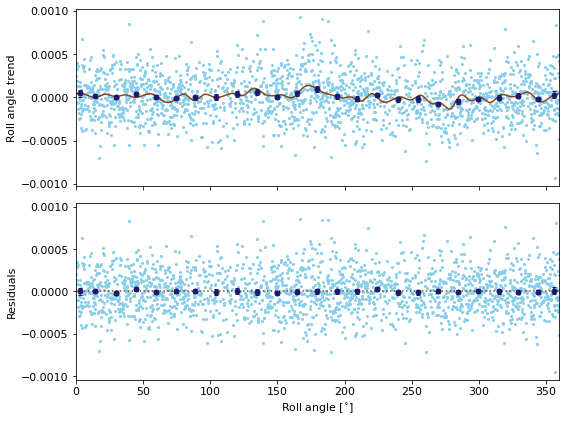

In [25]:
fig = dd.rollangle_plot()
#plt.ylim([-0.001, 0.001])

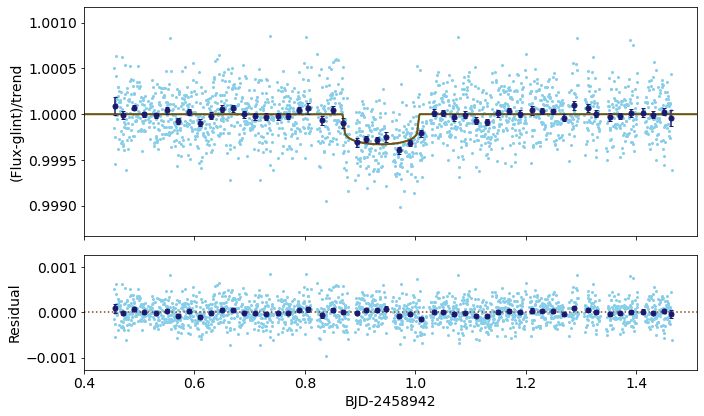

In [26]:
dd.plot_lmfit(binwidth=0.02, figsize=(10,6), fontsize=14, detrend=True);
#plt.ylim([-0.001, 0.001])

In [27]:
result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
T_0,0.93788577,8.9935e-04,(0.10%),0.9256099998128775,-inf,inf,True,
P,9.55210500,0.00000000,(0.00%),9.552105,-inf,inf,False,
D,3.1766e-04,1.8332e-05,(5.77%),0.00029887737956038244,7.4719e-05,0.00119551,True,
W,0.01463261,1.6919e-04,(1.16%),0.01646670201664101,0.00411668,0.06586681,True,
b,0.70797178,0.02627899,(3.71%),0.5,0.00000000,1.00000000,True,
f_c,0.00000000,0.00000000,,0.0,-inf,inf,False,
f_s,0.00000000,0.00000000,,0.0,-inf,inf,False,
h_1,0.76862409,0.00000000,(0.00%),0.7686240854550332,-inf,inf,False,
h_2,0.46152869,0.00000000,(0.00%),0.46152869255036916,-inf,inf,False,
c,0.99993514,6.0762e-06,(0.00%),1,0.49947799,2.00177181,True,


In the end, let's save our results in a file!

In [28]:
dd.save()

'HD_106315__CH_PR100041_TG000802_V0200.dataset'